In [20]:
HQA_SIG_SAVE_PATH = '../for_armani/best_checkpoints/hqa_kl_64_64.pt'
EFFICIENTNET_MODULATIONS_SAVE_PATH = './checkpoints/efficientnet_modulations.pt'

In [95]:
import torch
from hqa_lightning import HQA2D_Lightning
import matplotlib.pyplot as plt
from hqa_lightning_1D import HQA
from torchsig.datasets.modulations import ModulationsDataset
import torchsig.transforms as ST
from sklearn.metrics import accuracy_score
import torchattacks
import matplotlib.pyplot as plt
from scipy import signal as sp
import numpy as np
from torchvision.transforms import ToPILImage

import os

device = "cuda" if torch.cuda.is_available() else "cpu"
print("Device: ", device)

Device:  cuda


In [114]:
if os.path.exists(HQA_SIG_SAVE_PATH ):
    hqa_model = torch.load(HQA_SIG_SAVE_PATH).to(device).eval()
    print(f"Loaded {len(hqa_model)} layer model from checkpoint.")
else:
    print("HQA checkpoint not found!")

if os.path.exists(EFFICIENTNET_MODULATIONS_SAVE_PATH):
    eff_model = torch.load(EFFICIENTNET_MODULATIONS_SAVE_PATH).to(device).eval()
    print(f"Loaded efficientnet classifier from checkpoint.")
else:
    print("Classifier checkpoint not found!")

def reconstruct(layer, attack=None):
    def _reconstruct(x, y):
        if attack is not None:
            x = attack(x, y)
        if layer >= 0:
            x = x.to(hqa_model.device)
            x_recon = hqa_model[layer].reconstruct(x)
            return x_recon
        return x
    return _reconstruct

Loaded 5 layer model from checkpoint.
Loaded efficientnet classifier from checkpoint.


In [23]:
NORM = None
classes = ["4ask","8pam","16psk","32qam_cross","2fsk","ofdm-256"]
num_classes = len(classes)
training_samples_per_class = 8000
valid_samples_per_class = 2000
test_samples_per_class = 100
num_workers=32
num_iq_samples=1024
batch_size=64

train_datapoints = num_classes * training_samples_per_class
val_datapoints   = num_classes * valid_samples_per_class
test_datapoints  = num_classes * test_samples_per_class
total_datapoints = train_datapoints + val_datapoints + test_datapoints

train_transform, test_transform = [], []

if NORM is not None:
    train_transform.append(ST.Normalize(norm=NORM))
    test_transform.append(ST.Normalize(norm=NORM))



train_transform.append(ST.ComplexTo2D())
test_transform.append(ST.ComplexTo2D())

train_transform = ST.Compose(train_transform)
test_transform = ST.Compose(test_transform)

ds_train = ModulationsDataset(
        classes=classes,
        use_class_idx=True,
        level=0,
        num_iq_samples=num_iq_samples,
        num_samples=train_datapoints,
        include_snr=False,
        transform = train_transform
    )

ds_val = ModulationsDataset(
        classes=classes,
        use_class_idx=True,
        level=0,
        num_iq_samples=num_iq_samples,
        num_samples=val_datapoints,
        include_snr=False,
        transform = test_transform
    )

ds_test = ModulationsDataset(
        classes=classes,
        use_class_idx=True,
        level=0,
        num_iq_samples=num_iq_samples,
        num_samples=test_datapoints,
        include_snr=False,
        transform = test_transform,
        target_transform = ST.DescToClassIndex(class_list=classes)
    )

dl_train = torch.utils.data.DataLoader(
    ds_train,
    shuffle=True,
    num_workers=15,
    batch_size=batch_size
)

dl_val = torch.utils.data.DataLoader(
    ds_val,
    shuffle=False,
    num_workers=num_workers,
    batch_size=batch_size
)

dl_test = torch.utils.data.DataLoader(
    ds_test,
    shuffle=False,
    num_workers=15,
    batch_size=16
)

In [107]:
def plot_spectrogram(iq_tensor, ax=None):
    i = iq_tensor[0].cpu().numpy()
    q = iq_tensor[1].cpu().numpy()
    iq_data = i + q*1j
    _, _, spectrogram = sp.spectrogram(
            x=iq_data,
            fs=1,
            window=sp.windows.tukey(256, 0.25),
            nperseg=256,
            noverlap=None,
            nfft=None,
            return_onesided=False,
        )
    spectrogram = 20 * np.log10(np.fft.fftshift(np.abs(spectrogram), axes=0))
    if ax is None:
        plt.imshow(
            spectrogram,
            vmin=np.min(spectrogram[spectrogram != -np.inf]),
            vmax=np.max(spectrogram[spectrogram != np.inf]),
            aspect="auto",
            cmap="jet",
        )
        plt.xticks([])
        plt.yticks([])
        plt.show()
    else:
        ax.imshow(
            spectrogram,
            vmin=np.min(spectrogram[spectrogram != -np.inf]),
            vmax=np.max(spectrogram[spectrogram != np.inf]),
            aspect="auto",
            cmap="jet"
        )
        ax.set_xticks([])
        ax.set_yticks([])

In [24]:
def get_preds(classifier, dataloader, transform=None):
    """
    Returns a tuple containing an array of true labels and an array of predicted labels

    ** Modification for signals: Transforms from double -> float
    """
    classifier = classifier.eval()
    Y = []
    Y_pred = []
    for x, y in dataloader:
        x = x.float()
        if transform is not None:
            x = transform(x, y)
        x = x.to(classifier.device)
        y_pred = classifier(x)
        label_pred = torch.argmax(y_pred, dim=1)
        Y.extend(y)
        Y_pred.extend(label_pred)
    Y = list(map(lambda y : y.item(), Y))
    Y_pred = list(map(lambda y : y.item(), Y_pred))
    return Y, Y_pred

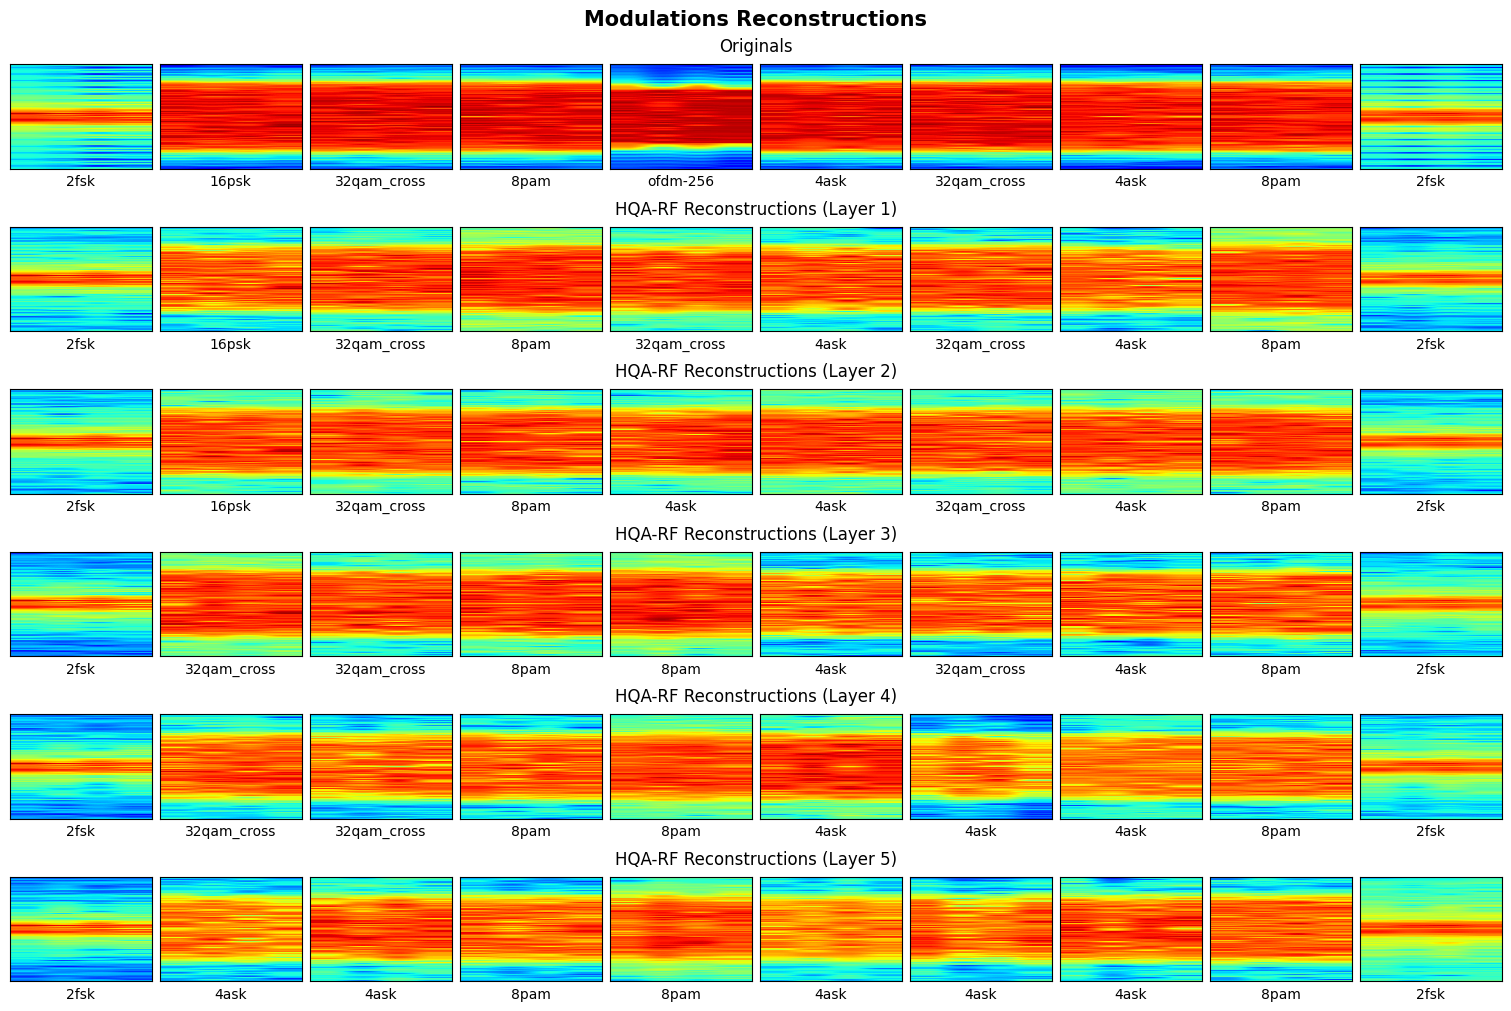

In [131]:
num_recons = 10

dataset = dl_train.dataset

x, y = next(iter(dl_train))
x = x.float()
# create 3x1 subplots
fig, axs = plt.subplots(nrows=len(epsilons) + 1, ncols=1, constrained_layout=True, figsize=(15,10))
fig.suptitle('Modulations Reconstructions', fontweight="bold", fontsize=15)

# clear subplots
for ax in axs:
    ax.remove()

# add subfigure per subplot
gridspec = axs[0].get_subplotspec().get_gridspec()
subfigs = [fig.add_subfigure(gs) for gs in gridspec]

for row, subfig in enumerate(subfigs):
    axs = subfig.subplots(nrows=1, ncols=num_recons)
    if row == 0:
        subfig.suptitle(f'Originals')
        y_pred = eff_model(x.to(eff_model.device))[:num_recons]
        y_pred = y_pred.argmax(axis=1)
        y_pred = list(map(lambda label : classes[label.item()], y_pred))
        for ndx, x_original in enumerate(x[:num_recons]):
            axis = axs[ndx]
            plot_spectrogram(x_original, ax=axis)
            axis.set_xlabel(y_pred[ndx])
    else:
        subfig.suptitle(f'HQA-RF Reconstructions (Layer {row})')
        recons = hqa_model[row - 1].reconstruct(x.to(hqa_model.device))
        y_pred = eff_model(recons.to(eff_model.device))[:num_recons]
        y_pred = y_pred.argmax(axis=1)
        y_pred = list(map(lambda label : classes[label.item()], y_pred))
        for img_ndx, recon in enumerate(recons[:num_recons]):
            axis = axs[img_ndx]
            plot_spectrogram(recon, ax=axis)
            axis.set_xlabel(y_pred[img_ndx])
plt.savefig("resources/modulations_reconstructions.png")
plt.show()

In [38]:
accuracies_no_attack = []

Y, Y_pred = get_preds(eff_model, dl_test)
accuracy = accuracy_score(Y,Y_pred)
print("Original Data Classification Accuracy: ", accuracy)
accuracies_no_attack.append(accuracy)

for index, layer in enumerate(hqa_model):
    Y, Y_pred = get_preds(eff_model, dl_test, transform=reconstruct(index))
    accuracy = accuracy_score(Y,Y_pred)
    accuracies_no_attack.append(accuracy)
    print(f"Layer {index} Reconstructions Classification Accuracy: ", accuracy)

Original Data Classification Accuracy:  1.0
Layer 0 Reconstructions Classification Accuracy:  0.8333333333333334
Layer 1 Reconstructions Classification Accuracy:  0.825
Layer 2 Reconstructions Classification Accuracy:  0.6666666666666666
Layer 3 Reconstructions Classification Accuracy:  0.6483333333333333
Layer 4 Reconstructions Classification Accuracy:  0.52


In [115]:
accuracies_fgsm_attack_0001 = []
accuracies_fgsm_attack_001 = []
accuracies_fgsm_attack_01 = []
accuracies_fgsm_attack_05 = []
accuracies_fgsm_attack_07 = []

epsilons = [0.0001, 0.001, 0.01, 0.05, 0.07]

eps_to_array = {
    0.0001 : accuracies_fgsm_attack_0001,
    0.001 : accuracies_fgsm_attack_001,
    0.01 : accuracies_fgsm_attack_01,
    0.05 : accuracies_fgsm_attack_05,
    0.07 : accuracies_fgsm_attack_07
}

for epsilon in epsilons:
    attack = torchattacks.FGSM(eff_model, eps=epsilon)
    Y, Y_pred = get_preds(eff_model, dl_test, transform=reconstruct(-1, attack=attack))
    accuracy = accuracy_score(Y,Y_pred)
    print(f"Attack [FGSM eps={epsilon}] Accuracy: ", accuracy)
    eps_to_array[epsilon].append(accuracy)
    for index, layer in enumerate(hqa_model):
        Y, Y_pred = get_preds(eff_model, dl_test, transform=reconstruct(index, attack=attack))
        accuracy = accuracy_score(Y,Y_pred)
        eps_to_array[epsilon].append(accuracy)
        print(f"Layer {index} Reconstructions [FGSM eps={epsilon}] Accuracy: ", accuracy)

Attack [FGSM eps=0.0001] Accuracy:  0.3233333333333333
Layer 0 Reconstructions [FGSM eps=0.0001] Accuracy:  0.16666666666666666
Layer 1 Reconstructions [FGSM eps=0.0001] Accuracy:  0.16666666666666666
Layer 2 Reconstructions [FGSM eps=0.0001] Accuracy:  0.16666666666666666
Layer 3 Reconstructions [FGSM eps=0.0001] Accuracy:  0.17333333333333334
Layer 4 Reconstructions [FGSM eps=0.0001] Accuracy:  0.17666666666666667
Attack [FGSM eps=0.001] Accuracy:  0.315
Layer 0 Reconstructions [FGSM eps=0.001] Accuracy:  0.16666666666666666
Layer 1 Reconstructions [FGSM eps=0.001] Accuracy:  0.16666666666666666
Layer 2 Reconstructions [FGSM eps=0.001] Accuracy:  0.16666666666666666
Layer 3 Reconstructions [FGSM eps=0.001] Accuracy:  0.175
Layer 4 Reconstructions [FGSM eps=0.001] Accuracy:  0.175
Attack [FGSM eps=0.01] Accuracy:  0.29333333333333333
Layer 0 Reconstructions [FGSM eps=0.01] Accuracy:  0.16666666666666666
Layer 1 Reconstructions [FGSM eps=0.01] Accuracy:  0.16666666666666666
Layer 2 Rec

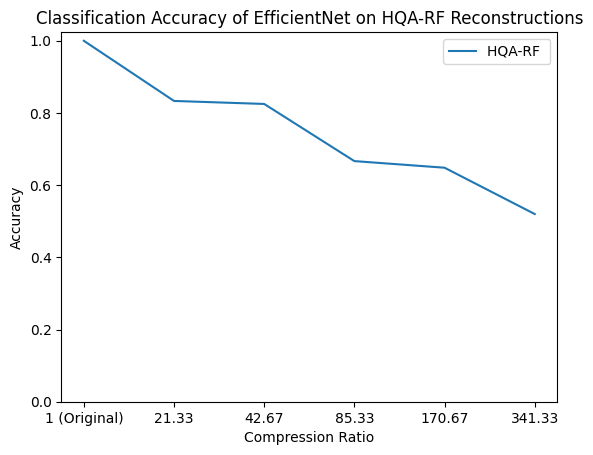

In [122]:
layers = ["1 (Original)", "21.33", "42.67", "85.33", "170.67", "341.33"]
plt.plot(layers, accuracies_no_attack, label="HQA-RF ")

plt.title("Classification Accuracy of EfficientNet on HQA-RF Reconstructions")
plt.ylabel("Accuracy")
plt.xlabel("Compression Ratio")
plt.ylim(0)
plt.legend()
plt.savefig("./resources/modulations_accuracy_curve.png")
plt.show()

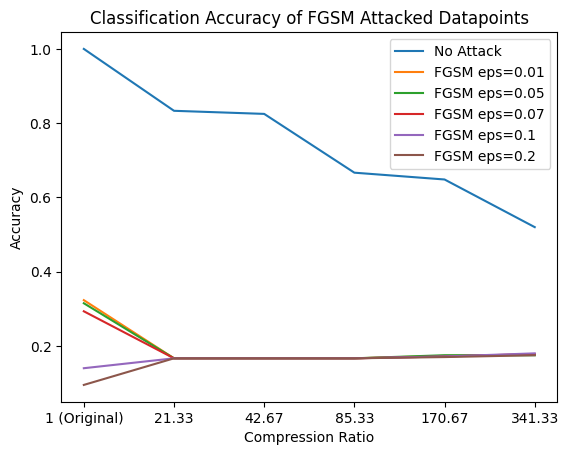

In [123]:
layers = ["1 (Original)", "21.33", "42.67", "85.33", "170.67", "341.33"]
plt.plot(layers, accuracies_no_attack, label="No Attack")
plt.plot(layers, accuracies_fgsm_attack_0001, label="FGSM eps=0.01")
plt.plot(layers, accuracies_fgsm_attack_001, label="FGSM eps=0.05")
plt.plot(layers, accuracies_fgsm_attack_01, label="FGSM eps=0.07")
plt.plot(layers, accuracies_fgsm_attack_05, label="FGSM eps=0.1")
plt.plot(layers, accuracies_fgsm_attack_07, label="FGSM eps=0.2")

plt.title("Classification Accuracy of FGSM Attacked Datapoints")
plt.ylabel("Accuracy")
plt.xlabel("Compression Ratio")
plt.legend()
plt.savefig("./resources/modulations_fgsm_reconstructions.png")
plt.show()

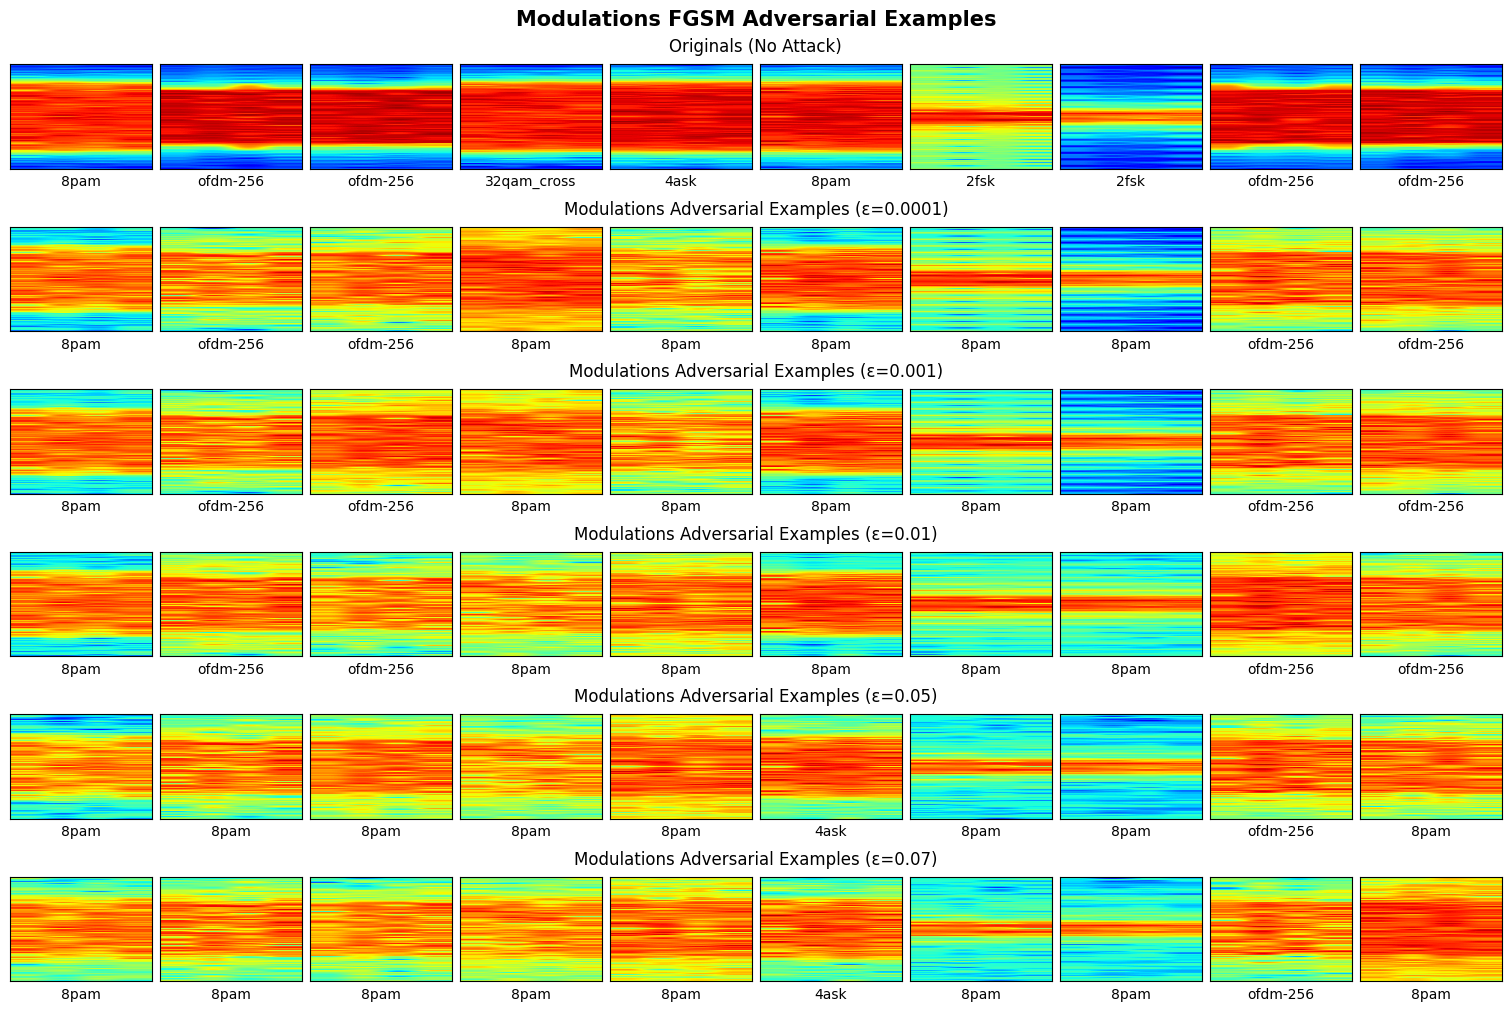

In [132]:


num_attacked = 10

dataset = dl_train.dataset

epsilons = [0.0001, 0.001, 0.01, 0.05, 0.07]
x, y = next(iter(dl_train))
x = x.float()
# create 3x1 subplots
fig, axs = plt.subplots(nrows=len(epsilons) + 1, ncols=1, constrained_layout=True, figsize=(15,10))
fig.suptitle('Modulations FGSM Adversarial Examples', fontweight="bold", fontsize=15)

# clear subplots
for ax in axs:
    ax.remove()

# add subfigure per subplot
gridspec = axs[0].get_subplotspec().get_gridspec()
subfigs = [fig.add_subfigure(gs) for gs in gridspec]

for row, subfig in enumerate(subfigs):
    axs = subfig.subplots(nrows=1, ncols=num_attacked)
    if row == 0:
        subfig.suptitle(f'Originals (No Attack)')
        y_pred = eff_model(x.to(eff_model.device))[:num_attacked]
        y_pred = y_pred.argmax(axis=1)
        y_pred = list(map(lambda label : classes[label.item()], y_pred))
        for ndx, x_original in enumerate(x[:num_attacked]):
            axis = axs[ndx]
            plot_spectrogram(x_original, ax=axis)
            axis.set_xlabel(y_pred[ndx])
    else:
        epsilon = epsilons[row - 1]
        subfig.suptitle(f'Modulations Adversarial Examples (ε={epsilon})')
        attack = torchattacks.FGSM(eff_model, eps=epsilon)
        attacked_x = attack(x,y)
        attacked_y_pred = eff_model(attacked_x.to(eff_model.device))[:num_attacked]
        attacked_y_pred = attacked_y_pred.argmax(axis=1)
        attacked_y_pred = list(map(lambda label : classes[label.item()], attacked_y_pred))
        for img_ndx, x_attacked in enumerate(attacked_x[:num_attacked]):
            axis = axs[img_ndx]
            plot_spectrogram(x_attacked, ax=axis)
            axis.set_xlabel(attacked_y_pred[img_ndx])
plt.savefig("resources/modulations_fgsm.png")
plt.show()

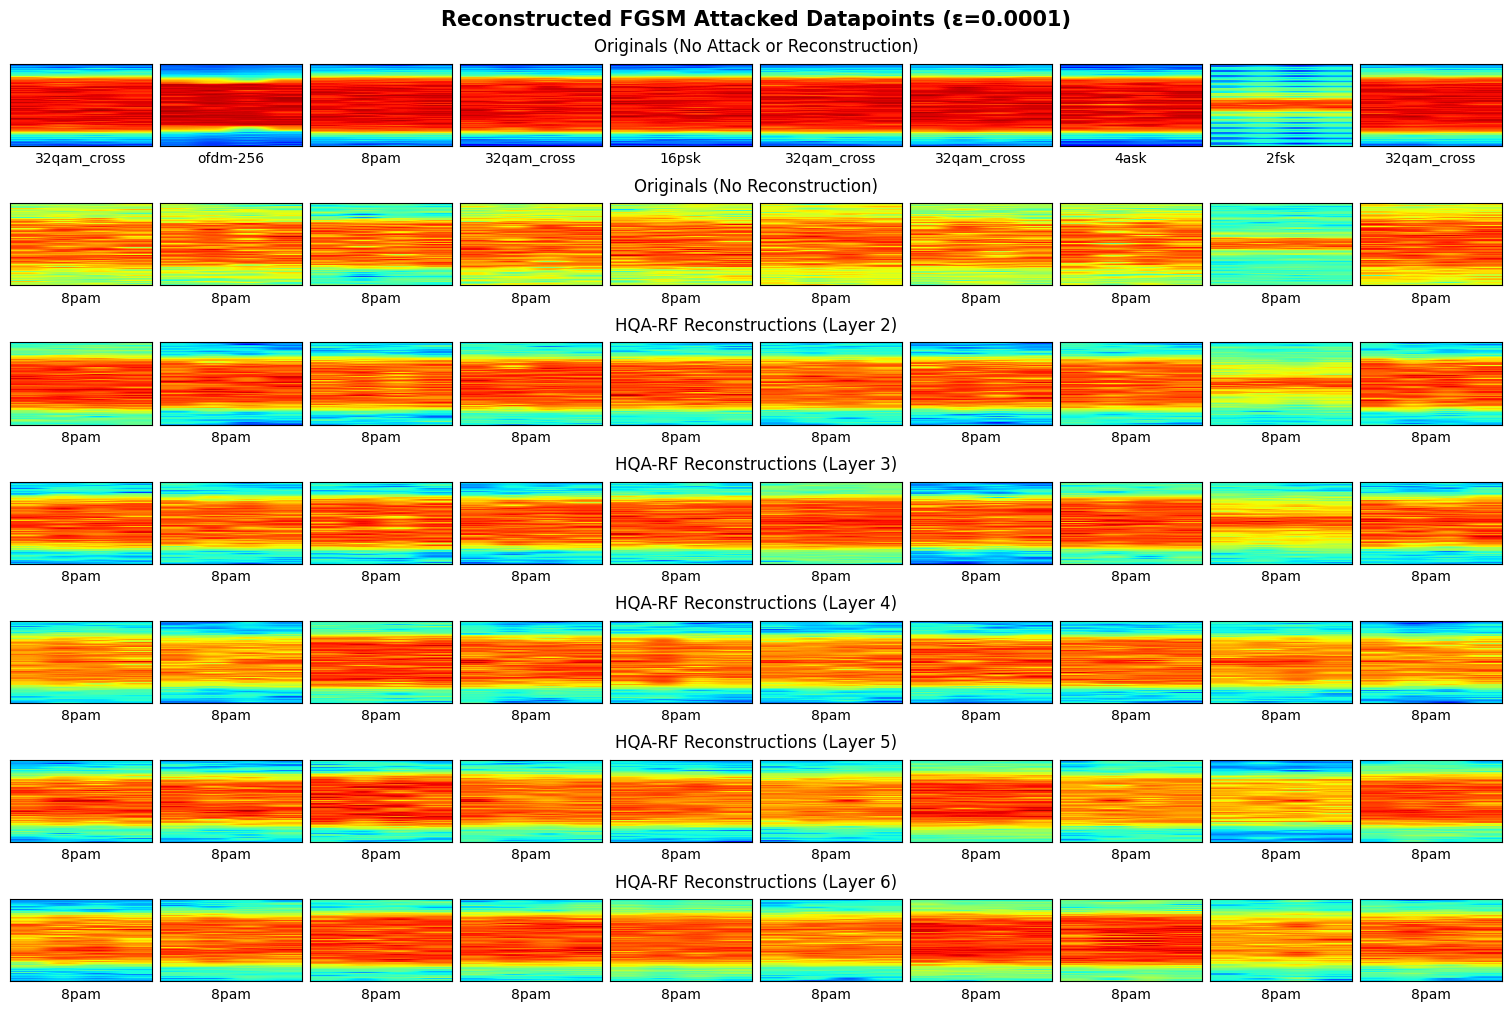

In [141]:
num_attacked = 10

x, y = next(iter(dl_train))
x = x.float()
# create 3x1 subplots
fig, axs = plt.subplots(nrows=len(epsilons) + 2, ncols=1, constrained_layout=True, figsize=(15,10))
fig.suptitle('Reconstructed FGSM Attacked Datapoints (ε=0.0001)', fontweight="bold", fontsize=15)

# clear subplots
for ax in axs:
    ax.remove()

# add subfigure per subplot
gridspec = axs[0].get_subplotspec().get_gridspec()
subfigs = [fig.add_subfigure(gs) for gs in gridspec]

attack = torchattacks.FGSM(eff_model, eps=epsilon)
x_attacked = attack(x,y)

for row, subfig in enumerate(subfigs):
    axs = subfig.subplots(nrows=1, ncols=num_attacked)
    if row == 0:
        subfig.suptitle(f"Originals (No Attack or Reconstruction)")
        y_pred = eff_model(x.to(eff_model.device))[:num_attacked]
        y_pred = y_pred.argmax(axis=1)
        y_pred = list(map(lambda label : classes[label.item()], y_pred))
        for ndx, x_orig in enumerate(x[:num_attacked]):
            axis = axs[ndx]
            plot_spectrogram(x_orig, ax=axis)
            axis.set_xlabel(y_pred[ndx])
        continue
    elif row == 1:
        subfig.suptitle(f'Originals (No Reconstruction)')
    else:
        subfig.suptitle(f'HQA-RF Reconstructions (Layer {row})')
        x_attacked = hqa_model[row - 2].reconstruct(x_attacked.to(hqa_model.device))
    y_pred = eff_model(x_attacked.to(eff_model.device))[:num_attacked]
    y_pred = y_pred.argmax(axis=1)
    y_pred = list(map(lambda label : classes[label.item()], y_pred))
    for ndx, x_atk in enumerate(x_attacked[:num_attacked]):
        axis = axs[ndx]
        plot_spectrogram(x_atk, ax=axis)
        axis.set_xlabel(y_pred[ndx])
plt.savefig("resources/modulations_reconstructed_aversarial.png")
plt.show()


torch.Size([2, 1024])


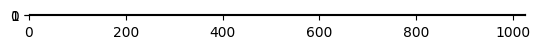